In [1]:
import numpy as np
from pr3_utils import load_data
from utils import *
from motion import *
from observation import *
from mapping import *
from visual_slam import *
from visualization import *

/Users/liaoweilin/Desktop/ece276a/PR/ECE276A_PR3/venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load the measurements
dataset = "03"
filename = f"../data/{dataset}.npz"
t, features, linear_velocity, angular_velocity, K, b, imu_T_cam = load_data(filename)

In [3]:
print(t.shape)
print(features.shape)
print(linear_velocity.shape)
print(angular_velocity.shape)

(1, 1010)
(4, 5105, 1010)
(3, 1010)
(3, 1010)


In [8]:
# use lesser featuares to speed up process
reduce_factor = 2
selected_feats = np.zeros((4, int(features.shape[1] / reduce_factor) + 1, features.shape[2]))
for i, idx in enumerate(range(0, int(features.shape[1]), reduce_factor)):
    selected_feats[:,i,:] = features[:,idx,:]
print(selected_feats.shape)

(4, 2553, 1010)


In [25]:
i_T_w, w_T_i = motion_model_prediction(t, linear_velocity, angular_velocity, noise_scale=10e-7)
print(w_T_i.shape)

100%|██████████| 1009/1009 [00:00<00:00, 24442.11it/s]

(4, 4, 1010)


(<Figure size 500x500 with 1 Axes>, <Axes: xlabel='x', ylabel='y'>)

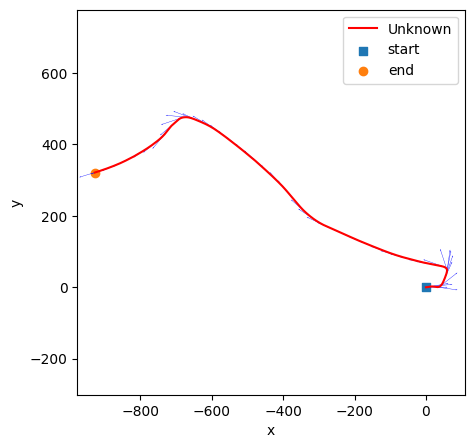

In [26]:
save_path = f"../fig/trajectory_2d_{dataset}_{reduce_factor}.png"
visualize_trajectory_2d(w_T_i, save_path, show_ori=True)

In [7]:
landmarks = landmark_mapping(selected_feats, i_T_w, K, b, imu_T_cam)

  0%|          | 4/1010 [00:00<00:33, 29.97it/s]

0
uL - uR: 9.709030151367188


  2%|▏         | 18/1010 [00:00<00:33, 29.45it/s]

uL - uR: 15.2620849609375


  5%|▌         | 51/1010 [00:01<00:29, 32.90it/s]

uL - uR: 9.56524658203125


  6%|▌         | 63/1010 [00:02<00:30, 30.57it/s]

uL - uR: 36.113128662109375


  8%|▊         | 82/1010 [00:02<00:27, 34.35it/s]

uL - uR: 15.276702880859375


  9%|▉         | 93/1010 [00:03<00:25, 36.05it/s]

uL - uR: 1.40753173828125


 10%|█         | 106/1010 [00:03<00:24, 36.18it/s]

100


 11%|█▏        | 116/1010 [00:03<00:23, 38.21it/s]

uL - uR: 17.35662841796875


 13%|█▎        | 129/1010 [00:04<00:25, 34.77it/s]

uL - uR: 23.038665771484375


 14%|█▍        | 142/1010 [00:04<00:22, 37.89it/s]

uL - uR: 1.43353271484375


 16%|█▋        | 165/1010 [00:05<00:21, 38.68it/s]

uL - uR: 30.25152587890625


 17%|█▋        | 174/1010 [00:05<00:26, 31.48it/s]

uL - uR: 1.7890625


 20%|█▉        | 199/1010 [00:06<00:21, 37.83it/s]

uL - uR: 4.69390869140625
200


 22%|██▏       | 218/1010 [00:06<00:26, 30.21it/s]

uL - uR: 9.71923828125


 25%|██▍       | 249/1010 [00:07<00:22, 33.18it/s]

uL - uR: 11.890625


 26%|██▋       | 267/1010 [00:08<00:20, 36.60it/s]

uL - uR: 3.96710205078125


 29%|██▊       | 288/1010 [00:08<00:18, 38.55it/s]

uL - uR: 2.8568115234375


 30%|███       | 303/1010 [00:09<00:20, 34.63it/s]

300
uL - uR: 5.05340576171875


 31%|███       | 315/1010 [00:09<00:23, 29.45it/s]

uL - uR: 6.747039794921875


 33%|███▎      | 329/1010 [00:09<00:19, 35.50it/s]

uL - uR: 3.388916015625


 35%|███▍      | 350/1010 [00:10<00:21, 30.28it/s]

uL - uR: 8.9029541015625


 37%|███▋      | 374/1010 [00:11<00:20, 31.28it/s]

uL - uR: 2.898193359375


 39%|███▊      | 391/1010 [00:12<00:27, 22.27it/s]

uL - uR: 4.9718017578125


 40%|███▉      | 400/1010 [00:13<00:44, 13.71it/s]

400


 41%|████      | 413/1010 [00:14<00:58, 10.28it/s]

uL - uR: 6.3795166015625


 43%|████▎     | 430/1010 [00:17<00:56, 10.26it/s]

uL - uR: 22.7054443359375


 45%|████▍     | 450/1010 [00:18<00:29, 18.72it/s]

uL - uR: 20.3974609375


 47%|████▋     | 472/1010 [00:19<00:16, 33.52it/s]

uL - uR: 10.83087158203125


 48%|████▊     | 480/1010 [00:19<00:15, 34.15it/s]

uL - uR: 1.65673828125


 49%|████▊     | 492/1010 [00:19<00:18, 28.06it/s]

uL - uR: 9.39990234375


 50%|█████     | 506/1010 [00:20<00:16, 29.88it/s]

500


 57%|█████▋    | 574/1010 [00:22<00:11, 36.73it/s]

uL - uR: 11.915771484375


 60%|█████▉    | 602/1010 [00:22<00:12, 31.77it/s]

600


 60%|██████    | 609/1010 [00:23<00:14, 26.96it/s]

uL - uR: 11.0068359375


 62%|██████▏   | 624/1010 [00:23<00:09, 40.53it/s]

uL - uR: 16.50592041015625
uL - uR: 18.1319580078125


 65%|██████▍   | 652/1010 [00:24<00:12, 28.58it/s]

uL - uR: 4.77362060546875


 67%|██████▋   | 680/1010 [00:25<00:10, 32.98it/s]

uL - uR: 15.093841552734375


 70%|██████▉   | 704/1010 [00:26<00:10, 30.22it/s]

uL - uR: 6.233978271484375
700


 73%|███████▎  | 739/1010 [00:27<00:08, 32.61it/s]

uL - uR: 6.99188232421875


 75%|███████▍  | 756/1010 [00:27<00:07, 33.36it/s]

uL - uR: 12.52880859375


 76%|███████▋  | 771/1010 [00:28<00:06, 35.88it/s]

uL - uR: 5.0174560546875


 77%|███████▋  | 780/1010 [00:28<00:07, 32.53it/s]

uL - uR: 6.079833984375


 80%|███████▉  | 804/1010 [00:29<00:05, 37.02it/s]

800
uL - uR: 3.76776123046875


 83%|████████▎ | 837/1010 [00:29<00:03, 44.79it/s]

uL - uR: 5.05523681640625


 84%|████████▍ | 852/1010 [00:30<00:04, 37.70it/s]

uL - uR: 5.23785400390625


 86%|████████▌ | 866/1010 [00:30<00:04, 33.80it/s]

uL - uR: 4.2957763671875


 88%|████████▊ | 885/1010 [00:31<00:03, 36.34it/s]

uL - uR: 19.005279541015625


 88%|████████▊ | 889/1010 [00:31<00:03, 31.68it/s]

uL - uR: 16.47833251953125


 89%|████████▉ | 902/1010 [00:32<00:04, 25.58it/s]

900


 91%|█████████ | 916/1010 [00:32<00:03, 24.91it/s]

uL - uR: 18.03326416015625


 92%|█████████▏| 928/1010 [00:33<00:03, 24.23it/s]

uL - uR: 42.86004638671875


 94%|█████████▎| 945/1010 [00:33<00:02, 29.45it/s]

uL - uR: 7.43450927734375


 95%|█████████▍| 957/1010 [00:34<00:01, 30.83it/s]

uL - uR: 22.0191650390625


 97%|█████████▋| 975/1010 [00:34<00:01, 32.89it/s]

uL - uR: 11.217529296875


 99%|█████████▊| 997/1010 [00:35<00:00, 35.07it/s]

uL - uR: 34.4984130859375


100%|█████████▉| 1005/1010 [00:35<00:00, 32.78it/s]

1000
uL - uR: 15.68035888671875


100%|██████████| 1010/1010 [00:35<00:00, 28.10it/s]


(<Figure size 500x500 with 1 Axes>, <Axes: xlabel='x', ylabel='y'>)

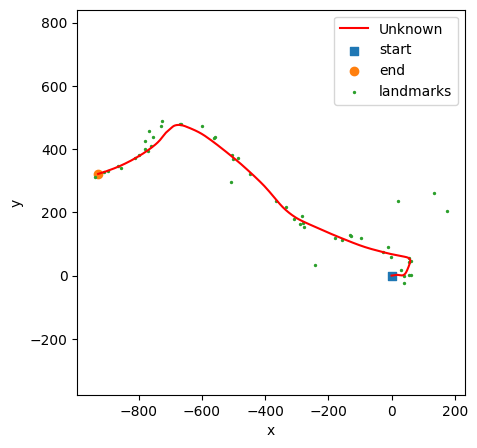

In [8]:
save_path = f"../fig/mapping_{dataset}_{reduce_factor}.png"
visualize(w_T_i, landmarks, save_path)

In [9]:
slam_iTw, slam_wTi, slam_landmarks = visual_slam(t, linear_velocity, angular_velocity, selected_feats, K, b, imu_T_cam)

  0%|          | 2/1009 [00:00<00:56, 17.97it/s]

0
uL - uR: 9.709030151367188


  2%|▏         | 17/1009 [00:00<00:45, 21.75it/s]

uL - uR: 15.2620849609375


  5%|▍         | 50/1009 [00:02<00:34, 28.11it/s]

uL - uR: 9.56524658203125


  6%|▋         | 64/1009 [00:02<00:33, 28.25it/s]

uL - uR: 36.113128662109375


  8%|▊         | 79/1009 [00:03<00:36, 25.16it/s]

uL - uR: 15.276702880859375


  9%|▊         | 88/1009 [00:03<00:40, 22.60it/s]

uL - uR: 1.40753173828125


 10%|█         | 101/1009 [00:05<02:15,  6.70it/s]

100


 11%|█         | 111/1009 [00:06<01:11, 12.56it/s]

uL - uR: 17.35662841796875


 12%|█▏        | 125/1009 [00:07<00:41, 21.08it/s]

uL - uR: 23.038665771484375


 14%|█▎        | 138/1009 [00:07<00:32, 26.78it/s]

uL - uR: 1.43353271484375


 16%|█▌        | 159/1009 [00:08<00:39, 21.78it/s]

uL - uR: 30.25152587890625


 17%|█▋        | 173/1009 [00:09<00:32, 25.64it/s]

uL - uR: 1.7890625


 20%|█▉        | 199/1009 [00:09<00:26, 30.06it/s]

uL - uR: 4.69390869140625
200


 22%|██▏       | 219/1009 [00:10<00:24, 32.09it/s]

uL - uR: 9.71923828125


 25%|██▍       | 251/1009 [00:11<00:28, 26.48it/s]

uL - uR: 11.890625


 26%|██▋       | 267/1009 [00:12<00:25, 28.88it/s]

uL - uR: 3.96710205078125


 28%|██▊       | 286/1009 [00:12<00:20, 34.77it/s]

uL - uR: 2.8568115234375


 30%|███       | 305/1009 [00:13<00:22, 31.94it/s]

300
uL - uR: 5.05340576171875


 32%|███▏      | 318/1009 [00:13<00:20, 33.87it/s]

uL - uR: 6.747039794921875


 32%|███▏      | 327/1009 [00:14<00:19, 35.38it/s]

uL - uR: 3.388916015625


 35%|███▍      | 353/1009 [00:15<00:20, 31.83it/s]

uL - uR: 8.9029541015625


 37%|███▋      | 375/1009 [00:15<00:18, 33.63it/s]

uL - uR: 2.898193359375


 39%|███▉      | 397/1009 [00:16<00:17, 35.29it/s]

uL - uR: 4.9718017578125


 40%|████      | 406/1009 [00:16<00:16, 35.57it/s]

400


 41%|████▏     | 417/1009 [00:17<00:24, 24.36it/s]

uL - uR: 6.3795166015625


 43%|████▎     | 434/1009 [00:17<00:19, 29.09it/s]

uL - uR: 22.7054443359375


 45%|████▍     | 452/1009 [00:18<00:17, 30.99it/s]

uL - uR: 20.3974609375


 47%|████▋     | 470/1009 [00:18<00:13, 41.02it/s]

uL - uR: 10.83087158203125


 48%|████▊     | 480/1009 [00:19<00:15, 33.83it/s]

uL - uR: 1.65673828125


 49%|████▉     | 494/1009 [00:19<00:13, 37.12it/s]

uL - uR: 9.39990234375


 50%|█████     | 506/1009 [00:19<00:15, 31.75it/s]

500


 57%|█████▋    | 574/1009 [00:21<00:11, 38.17it/s]

uL - uR: 11.915771484375


 60%|█████▉    | 604/1009 [00:22<00:12, 31.93it/s]

600
uL - uR: 11.0068359375


 61%|██████▏   | 620/1009 [00:23<00:11, 33.27it/s]

uL - uR: 16.50592041015625


 63%|██████▎   | 631/1009 [00:23<00:14, 25.65it/s]

uL - uR: 18.1319580078125


 65%|██████▍   | 653/1009 [00:24<00:10, 32.54it/s]

uL - uR: 4.77362060546875


 67%|██████▋   | 678/1009 [00:25<00:11, 28.06it/s]

uL - uR: 15.093841552734375


 69%|██████▉   | 701/1009 [00:26<00:12, 25.28it/s]

uL - uR: 6.233978271484375
700


 74%|███████▎  | 744/1009 [00:27<00:08, 32.15it/s]

uL - uR: 6.99188232421875


 75%|███████▍  | 756/1009 [00:28<00:08, 29.69it/s]

uL - uR: 12.52880859375


 76%|███████▋  | 771/1009 [00:28<00:08, 28.22it/s]

uL - uR: 5.0174560546875


 77%|███████▋  | 781/1009 [00:29<00:08, 25.94it/s]

uL - uR: 6.079833984375


 80%|███████▉  | 804/1009 [00:29<00:06, 33.14it/s]

800
uL - uR: 3.76776123046875


 82%|████████▏ | 832/1009 [00:31<00:08, 21.04it/s]

uL - uR: 5.05523681640625


 85%|████████▍ | 853/1009 [00:31<00:05, 26.84it/s]

uL - uR: 5.23785400390625


 86%|████████▌ | 864/1009 [00:32<00:05, 25.30it/s]

uL - uR: 4.2957763671875


 87%|████████▋ | 880/1009 [00:32<00:04, 28.11it/s]

uL - uR: 19.005279541015625


 88%|████████▊ | 892/1009 [00:33<00:04, 28.21it/s]

uL - uR: 16.47833251953125


 89%|████████▉ | 903/1009 [00:33<00:04, 25.97it/s]

900


 90%|█████████ | 912/1009 [00:34<00:04, 22.27it/s]

uL - uR: 18.03326416015625


 92%|█████████▏| 930/1009 [00:34<00:03, 24.93it/s]

uL - uR: 42.86004638671875


 93%|█████████▎| 943/1009 [00:35<00:03, 20.51it/s]

uL - uR: 7.43450927734375


 95%|█████████▍| 956/1009 [00:35<00:01, 29.03it/s]

uL - uR: 22.0191650390625


 97%|█████████▋| 974/1009 [00:36<00:01, 32.09it/s]

uL - uR: 11.217529296875


 98%|█████████▊| 991/1009 [00:37<00:00, 34.27it/s]

uL - uR: 34.4984130859375


100%|█████████▉| 1007/1009 [00:37<00:00, 32.73it/s]

1000
uL - uR: 15.68035888671875


100%|██████████| 1009/1009 [00:37<00:00, 26.79it/s]


In [ ]:
save_path = f"../fig/slam_{dataset}_{reduce_factor}.png"
visualize(slam_wTi, slam_landmarks, save_path)

In [ ]:
save_path = f"../fig/compare_{dataset}_{reduce_factor}.png"
combine_result(w_T_i, slam_wTi, landmarks, slam_landmarks, save_path)